# Automatic Detection Of Lumpy Skin Disease Using DenseNet 121

# Importing Libraries

In [5]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

2024-09-26 22:49:04.630009: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 22:49:04.632089: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 22:49:04.672974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 22:49:04.673993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 22:49:05.496532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [ ]:
# download dataset from https://www.kaggle.com/datasets/kaushalrimal619/lumpy-skin-disease-cow-images?resource=download

In [6]:
# Base Path for all files
data_dir = '/home/santhosh/Downloads/archive'  # change the Dataset path

# Load Images For Training & Testing

In [7]:
###### Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                    ),
}

Found 3600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# Initialize Densenet-121 Pretrained Model

In [ ]:
# Download Weights from https://www.kaggle.com/datasets/xhlulu/densenet-keras

In [9]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = DenseNet121(weights=None, include_top=False, input_shape=(256, 256, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('/home/santhosh/Downloads/DenseNet-BC-121-32-no-top.h5')

# Setting the Training of all layers of InceptionV3 model to false (Freezing all the Layers)
base_model.trainable = False

In [10]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax') # 2 Output Neurons for 2 Classes
])

In [11]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# View Model Summary


In [12]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 8089154 (30.86 MB)
Trainable params: 1051650 (4.01 MB)
Non-trainable params: 7037504 (26.85 MB)
____________

# Model Building


In [17]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [18]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 112
validation_steps : 12


# Model Training


In [19]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
112/112 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9546
Epoch 1: val_accuracy improved from -inf to 0.83594, saving model to ./model_01-0.84.h5
112/112 [==============================] - 243s 2s/step - loss: 0.1417 - accuracy: 0.9546 - val_loss: 0.4308 - val_accuracy: 0.8359
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9905
Epoch 2: val_accuracy improved from 0.83594 to 0.84896, saving model to ./model_02-0.85.h5
112/112 [==============================] - 246s 2s/step - loss: 0.0378 - accuracy: 0.9905 - val_loss: 0.3460 - val_accuracy: 0.8490
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9922
Epoch 3: val_accuracy did not improve from 0.84896
112/112 [==============================] - 244s 2s/step - loss: 0.0272 - accuracy: 0.9922 - val_loss: 0.4402 - val_accuracy: 0.8438
Epoch 4/10
112/112 [==============================] - ETA: 0s - loss: 0.0228 - accurac

KeyboardInterrupt: 

# Model Evaluation


In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [22]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

13/13 [==============================] - 20s 1s/step - loss: 0.3755 - accuracy: 0.8650
test accuracy :  0.8650000095367432


In [24]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("./model_05-0.87.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(256, 256))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'Lumpy Skin', 1: 'Normal Skin'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

# |Model Testing With Graphs


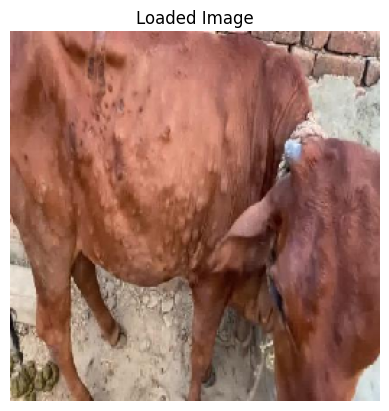

1/1 [==============================] - 0s 99ms/step


Maximum Probability:  0.99944144
Classified: Lumpy Skin 



-------------------Individual Probability--------------------------------

LUMPY SKIN : 99.94 %
NORMAL SKIN : 0.06 %


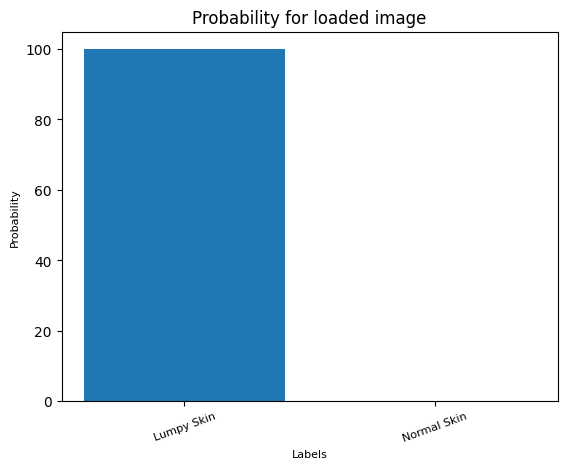

In [27]:
predict("/home/santhosh/Downloads/archive/infected/infected/infected (86).png")

In [60]:
predict("../input/lumpyskindiseaseresearch/Normal Skin/00000032.jpg")

AttributeError: 'numpy.ndarray' object has no attribute 'load_img'

In [39]:
import cv2

In [72]:
image = cv2.imread("/home/santhosh/Downloads/archive/infected/infected/infected (86).png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

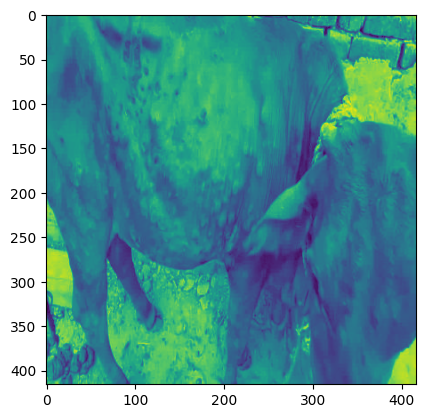

In [73]:
plt.imshow(image)

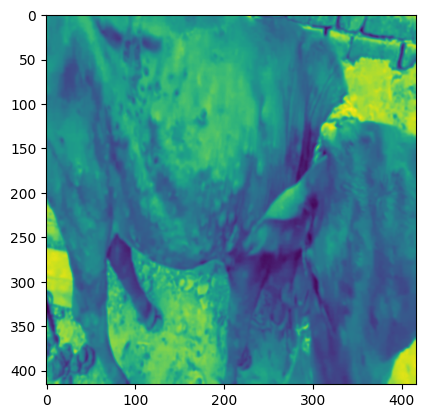

In [74]:
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
plt.imshow(blurred_image)

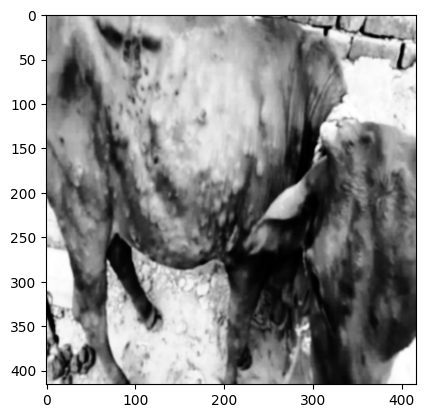

In [76]:
equalized_image = cv2.equalizeHist(blurred_image)
equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)
plt.imshow(equalized_image)

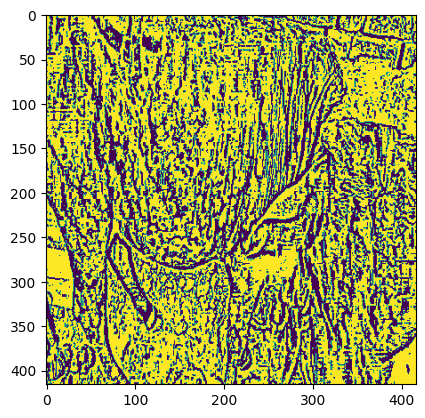

In [65]:
adaptive_thresh = cv2.adaptiveThreshold(
    equalized_image, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, 
    11, 2
)
plt.imshow(adaptive_thresh)

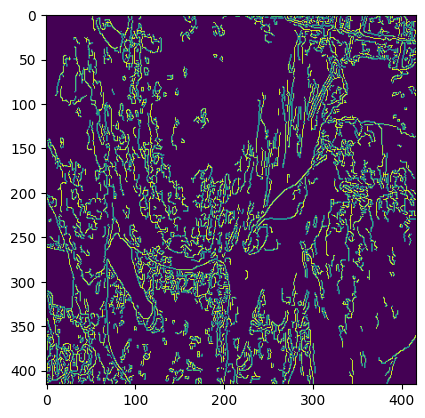

In [66]:
edges = cv2.Canny(equalized_image, 100, 200)
plt.imshow(edges)